In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import sys
import csv
import numpy as np
import os
import sqlite3
import copy
#import DBF

print(f"Python Version = {sys.version}")
print(f"Pandas Version = {pd.__version__}")

Python Version = 3.7.3 (default, Mar 27 2019, 22:11:17) 
[GCC 7.3.0]
Pandas Version = 0.24.2


# Definitions

1) Fine Fuel Moisture Code
The Fine Fuel Moisture Code (FFMC) is a numeric rating of the moisture content of litter and other cured fine fuels. This code is an indicator of the relative ease of ignition and the flammability of fine fuel.

2) Duff Moisture Code
The Duff Moisture Code (DMC) is a numeric rating of the average moisture content of loosely compacted organic layers of moderate depth. This code gives an indication of fuel consumption in moderate duff layers and medium-size woody material.

3) Drought Code
The Drought Code (DC) is a numeric rating of the average moisture content of deep, compact organic layers. This code is a useful indicator of seasonal drought effects on forest fuels and the amount of smoldering in deep duff layers and large logs.

4)  Initial Spread Index
The Initial Spread Index (ISI) is a numeric rating of the expected rate of fire spread. It combines the effects of wind and the FFMC on rate of spread without the influence of variable quantities of fuel.

https://cwfis.cfs.nrcan.gc.ca/background/summary/fwi

5) Temp
Temperature in Celsius degrees

6) RH
Relative humidity in %

7) Wind
Wind speed in km/h

8) Rain
Outside rain in mm/m2

9) Area
The burned area of the forest (in ha), ha = hectare = 2.47 acres

10) X
x-axis spatial coordinate within the Montesinho park map: 1 to 9 2

11) Y
y-axis spatial coordinate within the Montesinho park map: 2 to 9 3

Literature:

https://news.uci.edu/2019/09/17/uci-team-uses-machine-learning-to-help-tell-which-wildfires-will-burn-out-of-control/

In the original paper (Portugal - Montesinho fires), the best result (predicting burned area) was only using the 4 weather conditions: RH/Wind/Rain/Temp, and an SVM.

This: https://datasetsearch.research.google.com/search?query=wildfire%20area&docid=fchFFzqh0O3qjX3PAAAAAA%3D%3D has georeferenced and date/time referenced with areas. Could combine with weather data for those dates/times.

# Query shape of datasets and feature names

In [2]:
os.getcwd()

'/home/laura/W210/wildfireplus/EDA'

## Montesinho

In [3]:
montesinho = pd.read_csv('../data/Montesinho/forestfires.csv')

FileNotFoundError: [Errno 2] File b'../data/Montesinho/forestfires.csv' does not exist: b'../data/Montesinho/forestfires.csv'

In [22]:
print(montesinho.shape)
montesinho.head()

(517, 13)


,X,Y,month,day,FFMC,DMC,DC,ISI,temp,RH,wind,rain,area
0,7,5,mar,fri,86.2,26.2,94.3,5.1,8.2,51,6.7,0.0,0.0
1,7,4,oct,tue,90.6,35.4,669.1,6.7,18.0,33,0.9,0.0,0.0
2,7,4,oct,sat,90.6,43.7,686.9,6.7,14.6,33,1.3,0.0,0.0
3,8,6,mar,fri,91.7,33.3,77.5,9.0,8.3,97,4.0,0.2,0.0
4,8,6,mar,sun,89.3,51.3,102.2,9.6,11.4,99,1.8,0.0,0.0


## US Fires 1.88 Million

In [9]:
db = sqlite3.connect('../data/188millionuswildfires/FPA_FOD_20170508.sqlite')

In [10]:
cursorobj = db.cursor()
cursorobj.execute('SELECT name from sqlite_master where type = "table"')
tables1 = cursorobj.fetchall()
tables1

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('sql_statements_log',),
 ('SpatialIndex',),
 ('ElementaryGeometries',),
 ('KNN',),
 ('Fires',),
 ('idx_Fires_Shape',),
 ('idx_Fires_Shape_node',),
 ('idx_Fires_Shape_rowid',),
 ('idx_Fires_Shape_parent',),
 ('NWCG_UnitIDActive_20170109',)]

In [11]:
tables2 = copy.deepcopy(tables1)
del tables2[18:21]
tables2
del tables2[19]
tables2

[('spatial_ref_sys',),
 ('spatialite_history',),
 ('sqlite_sequence',),
 ('geometry_columns',),
 ('spatial_ref_sys_aux',),
 ('views_geometry_columns',),
 ('virts_geometry_columns',),
 ('geometry_columns_statistics',),
 ('views_geometry_columns_statistics',),
 ('virts_geometry_columns_statistics',),
 ('geometry_columns_field_infos',),
 ('views_geometry_columns_field_infos',),
 ('virts_geometry_columns_field_infos',),
 ('geometry_columns_time',),
 ('geometry_columns_auth',),
 ('views_geometry_columns_auth',),
 ('virts_geometry_columns_auth',),
 ('sql_statements_log',),
 ('Fires',),
 ('idx_Fires_Shape_node',),
 ('idx_Fires_Shape_rowid',),
 ('idx_Fires_Shape_parent',),
 ('NWCG_UnitIDActive_20170109',)]

In [12]:
for table in tables2:
    query = "SELECT * FROM " + table[0]
    #print(query)
    cursorobj.execute(query)
    names = [description[0] for description in cursorobj.description]
    print(table, names)

('spatial_ref_sys',) ['srid', 'auth_name', 'auth_srid', 'ref_sys_name', 'proj4text', 'srtext']
('spatialite_history',) ['event_id', 'table_name', 'geometry_column', 'event', 'timestamp', 'ver_sqlite', 'ver_splite']
('sqlite_sequence',) ['name', 'seq']
('geometry_columns',) ['f_table_name', 'f_geometry_column', 'geometry_type', 'coord_dimension', 'srid', 'spatial_index_enabled']
('spatial_ref_sys_aux',) ['srid', 'is_geographic', 'has_flipped_axes', 'spheroid', 'prime_meridian', 'datum', 'projection', 'unit', 'axis_1_name', 'axis_1_orientation', 'axis_2_name', 'axis_2_orientation']
('views_geometry_columns',) ['view_name', 'view_geometry', 'view_rowid', 'f_table_name', 'f_geometry_column', 'read_only']
('virts_geometry_columns',) ['virt_name', 'virt_geometry', 'geometry_type', 'coord_dimension', 'srid']
('geometry_columns_statistics',) ['f_table_name', 'f_geometry_column', 'last_verified', 'row_count', 'extent_min_x', 'extent_min_y', 'extent_max_x', 'extent_max_y']
('views_geometry_colum

In [13]:
usfires2 = pd.read_sql_query("SELECT datetime(DISCOVERY_DATE) as DISCOVERY_DATE, \
                             DISCOVERY_TIME, FIRE_SIZE, LATITUDE, LONGITUDE, \
                             datetime(CONT_DATE) as CONT_DATE, CONT_TIME \
                             FROM Fires",db)

In [14]:
usfires2.shape

(1880465, 7)

In [15]:
usfires2.head()

,DISCOVERY_DATE,DISCOVERY_TIME,FIRE_SIZE,LATITUDE,LONGITUDE,CONT_DATE,CONT_TIME
0,2005-02-02 00:00:00,1300,0.10,40.036944,-121.005833,2005-02-02 00:00:00,1730
1,2004-05-12 00:00:00,0845,0.25,38.933056,-120.404444,2004-05-12 00:00:00,1530
2,2004-05-31 00:00:00,1921,0.10,38.984167,-120.735556,2004-05-31 00:00:00,2024
3,2004-06-28 00:00:00,1600,0.10,38.559167,-119.913333,2004-07-03 00:00:00,1400
4,2004-06-28 00:00:00,1600,0.10,38.559167,-119.933056,2004-07-03 00:00:00,1200


In [19]:
usfires2['logArea'] = usfires2.apply(lambda row: np.log(row.FIRE_SIZE+1), axis=1)

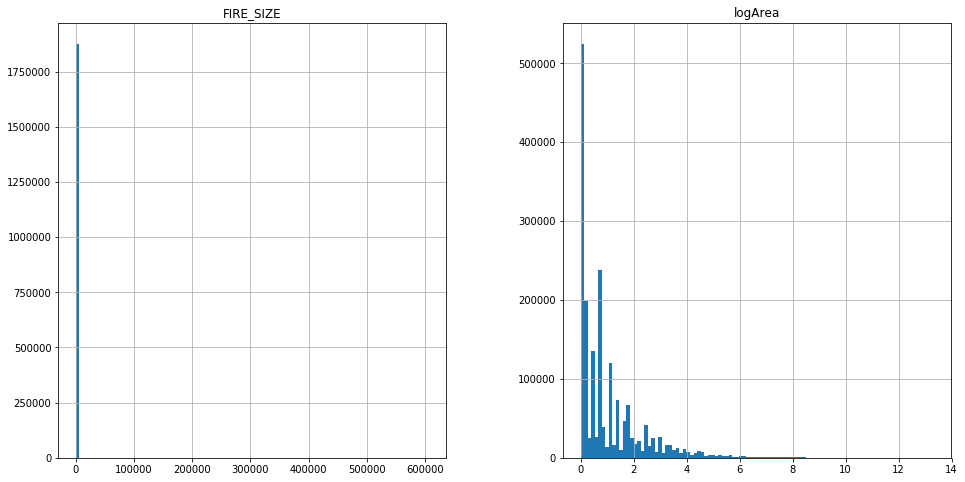

In [21]:
fig,axes = plt.subplots(1,2,figsize=(16,8))
usfires2.hist(column = "FIRE_SIZE", bins=100, ax = axes[0])
usfires2.hist(column = 'logArea', bins=100, ax=axes[1])
plt.show()

## Global Fire Atlas

## GeoMac

In [ ]:
geomac = sqlite3.connect('../data/188millionuswildfires/FPA_FOD_20170508.sqlite')

## Weather Data

1) cheapest seems to be DarkSky. 1000 per day for free
2) $0.0001 per request after that
3) Request: "
https://api.darksky.net/forecast/[key]/40.036944,-121.005833,2005-02-02T17:30:00"  (my api key removed)

Output is like this:
{"latitude":40.036944,"longitude":-121.005833,"timezone":"America/Los_Angeles","currently":{"time":1107394200,"precipIntensity":0,"precipProbability":0,"temperature":50.24,"apparentTemperature":50.41,"dewPoint":13.85,"humidity":0.23,"windSpeed":2.62,"windGust":13.17,"windBearing":24,"uvIndex":0},"hourly":{"data":[{"time":1107331200,"precipIntensity":0,"precipProbability":0,"temperature":39.73,"apparentTemperature":39.73,"dewPoint":12.45,"humidity":0.32,"windSpeed":1.23,"windGust":6.42,"windBearing":140,"uvIndex":0},{"time":1107334800,"precipIntensity":0,"precipProbability":0,"temperature":39.57,"apparentTemperature":39.57,"dewPoint":11.95,"humidity":0.32,"windSpeed":2.21,"windGust":5.8,"windBearing":72,"uvIndex":0},{"time":1107338400,"precipIntensity":0,"precipProbability":0,"temperature":38.69,"apparentTemperature":34.34,"dewPoint":13.27,"humidity":0.35,"windSpeed":5.79,"windGust":14.19,"windBearing":82,"uvIndex":0},{"time":1107342000,"precipIntensity":0,"precipProbability":0,"temperature":37.04,"apparentTemperature":37.04,"dewPoint":12.65,"humidity":0.36,"windSpeed":2.35,"windGust":9.56,"windBearing":98,"uvIndex":0},{"time":1107345600,"precipIntensity":0,"precipProbability":0,"temperature":36.26,"apparentTemperature":36.26,"dewPoint":12.71,"humidity":0.37,"windSpeed":1.16,"windGust":7.66,"windBearing":58,"uvIndex":0},{"time":1107349200,"precipIntensity":0,"precipProbability":0,"temperature":36.51,"apparentTemperature":36.51,"dewPoint":13.58,"humidity":0.39,"windSpeed":2.18,"windGust":6.93,"windBearing":71,"uvIndex":0},{"time":1107352800,"precipIntensity":0,"precipProbability":0,"temperature":36.4,"apparentTemperature":36.4,"dewPoint":12.17,"humidity":0.36,"windSpeed":2.48,"windGust":5.45,"windBearing":16,"uvIndex":0},{"time":1107356400,"precipIntensity":0,"precipProbability":0,"temperature":36.36,"apparentTemperature":36.36,"dewPoint":13.45,"humidity":0.39,"windSpeed":1.74,"windGust":5.3,"windBearing":61,"uvIndex":0},{"time":1107360000,"precipIntensity":0,"precipProbability":0,"temperature":35.85,"apparentTemperature":35.85,"dewPoint":14.88,"humidity":0.42,"windSpeed":2.52,"windGust":6.53,"windBearing":87},{"time":1107363600,"precipIntensity":0,"precipProbability":0,"temperature":42.06,"apparentTemperature":40.19,"dewPoint":13.16,"humidity":0.3,"windSpeed":3.48,"windGust":8.05,"windBearing":91},{"time":1107367200,"precipIntensity":0,"precipProbability":0,"temperature":46.17,"apparentTemperature":46.17,"dewPoint":16.52,"humidity":0.3,"windSpeed":2.71,"windGust":7.32,"windBearing":126},{"time":1107370800,"precipIntensity":0,"precipProbability":0,"temperature":47.55,"apparentTemperature":47.55,"dewPoint":21.59,"humidity":0.36,"windSpeed":2.72,"windGust":10.31,"windBearing":150},{"time":1107374400,"precipIntensity":0,"precipProbability":0,"temperature":52.04,"apparentTemperature":52.04,"dewPoint":20.52,"humidity":0.29,"windSpeed":4.29,"windGust":8.13,"windBearing":87},{"time":1107378000,"precipIntensity":0,"precipProbability":0,"temperature":55.54,"apparentTemperature":55.54,"dewPoint":19.53,"humidity":0.24,"windSpeed":4.84,"windGust":11.03,"windBearing":149},{"time":1107381600,"precipIntensity":0,"precipProbability":0,"temperature":56.34,"apparentTemperature":56.34,"dewPoint":17.37,"humidity":0.21,"windSpeed":5.54,"windGust":11.23,"windBearing":188},{"time":1107385200,"precipIntensity":0,"precipProbability":0,"temperature":57.34,"apparentTemperature":57.34,"dewPoint":15.65,"humidity":0.19,"windSpeed":6.36,"windGust":12.71,"windBearing":107},{"time":1107388800,"precipIntensity":0,"precipProbability":0,"temperature":53.57,"apparentTemperature":53.57,"dewPoint":15.64,"humidity":0.22,"windSpeed":6.13,"windGust":14.53,"windBearing":36},{"time":1107392400,"precipIntensity":0,"precipProbability":0,"temperature":52.58,"apparentTemperature":52.58,"dewPoint":14.07,"humidity":0.21,"windSpeed":3.32,"windGust":14.57,"windBearing":35},{"time":1107396000,"precipIntensity":0,"precipProbability":0,"temperature":47.79,"apparentTemperature":47.79,"dewPoint":13.74,"humidity":0.25,"windSpeed":2.6,"windGust":11.96,"windBearing":13,"uvIndex":0},{"time":1107399600,"precipIntensity":0,"precipProbability":0,"temperature":45.91,"apparentTemperature":43.25,"dewPoint":12.96,"humidity":0.26,"windSpeed":5.25,"windGust":13.55,"windBearing":80,"uvIndex":0},{"time":1107403200,"precipIntensity":0,"precipProbability":0,"temperature":43.25,"apparentTemperature":41.58,"dewPoint":14.25,"humidity":0.31,"windSpeed":3.45,"windGust":8.79,"windBearing":55,"uvIndex":0},{"time":1107406800,"precipIntensity":0,"precipProbability":0,"temperature":43.79,"apparentTemperature":43.79,"dewPoint":14.86,"humidity":0.31,"windSpeed":1.71,"windGust":6.29,"windBearing":158,"uvIndex":0},{"time":1107410400,"precipIntensity":0,"precipProbability":0,"temperature":42.36,"apparentTemperature":42.36,"dewPoint":14.51,"humidity":0.32,"windSpeed":2.37,"windGust":12.25,"windBearing":43,"uvIndex":0},{"time":1107414000,"precipIntensity":0,"precipProbability":0,"temperature":41.2,"apparentTemperature":41.2,"dewPoint":12.53,"humidity":0.31,"windSpeed":1.56,"windGust":12.79,"windBearing":100,"uvIndex":0}]},"daily":{"data":[{"time":1107331200,"sunriseTime":1107357120,"sunsetTime":1107393960,"moonPhase":0.78,"precipIntensity":0,"precipIntensityMax":0,"precipProbability":0,"temperatureHigh":57.95,"temperatureHighTime":1107384600,"temperatureLow":38.42,"temperatureLowTime":1107439200,"apparentTemperatureHigh":57.45,"apparentTemperatureHighTime":1107384600,"apparentTemperatureLow":38.91,"apparentTemperatureLowTime":1107439200,"dewPoint":14.85,"humidity":0.31,"windSpeed":3.33,"windGust":14.83,"windGustTime":1107390840,"windBearing":76,"uvIndex":0,"uvIndexTime":1107331200,"temperatureMin":35.03,"temperatureMinTime":1107359100,"temperatureMax":57.95,"temperatureMaxTime":1107384600,"apparentTemperatureMin":34.3,"apparentTemperatureMinTime":1107338640,"apparentTemperatureMax":57.45,"apparentTemperatureMaxTime":1107384600}]},"flags":{"sources":["cmc","gfs","hrrr","icon","isd","madis","nam","sref"],"nearest-station":3.312,"units":"us"},"offset":-8}